In [114]:
import cv2
import pykitti
import numpy as np
from matplotlib import pyplot as plt

kitty_dir = 'kitti/drives'
kitty_date = '2011_09_26'
kitty_drive = '0002'

kitti = pykitti.raw(kitty_dir, kitty_date, kitty_drive, frames=range(10, 72))
K = kitti.calib.K_cam0
imgs = kitti.cam0

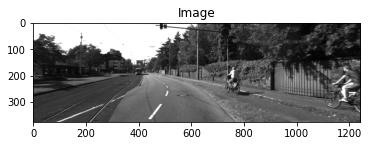

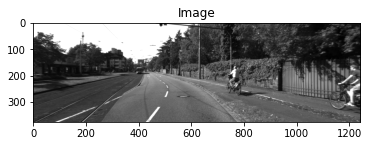

In [115]:
img1 = np.array(next(imgs))
img2 = np.array(next(imgs))
img3 = np.array(next(imgs))

plt.subplot(2, 1, 1)
plt.imshow(img1, cmap='gray')
plt.title('Image')
plt.show()
plt.subplot(2, 1, 2)
plt.imshow(img2, cmap='gray')
plt.title('Image')
plt.show()

## Detect Features

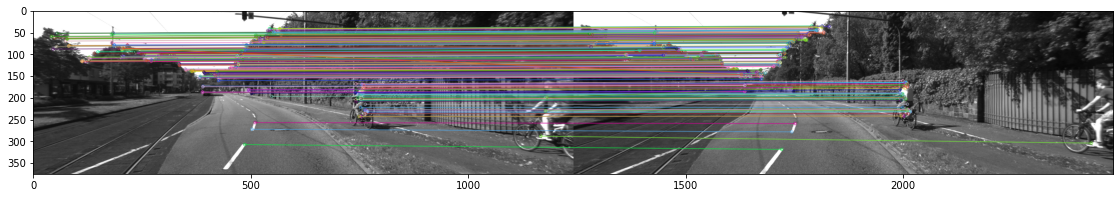

Keeping 71/314 points that match the fundamental matrix
E: [[ 6.31111248e-01  8.47665637e+01  1.94853123e+05]
 [-8.34506007e+01  6.84628749e-01  1.94870256e+05]
 [-1.94853122e+05 -1.94870783e+05  1.18627539e-01]]


In [116]:
def detect_matches_and_E(img1, img2, draw=True):
	# Find Matches
	# From: https://stackoverflow.com/a/33670318
	orb = cv2.ORB_create()
	kp1, des1 = orb.detectAndCompute(img1, None)
	kp2, des2 = orb.detectAndCompute(img2, None)
	bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
	matches = bf.match(des1, des2)
	matches = sorted(matches, key=lambda x: x.distance)

	if draw:
		match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)
		plt.figure(figsize=(30, 3))
		plt.imshow(match_img)
		plt.show()

	# Find Points
	# From book
	imgpts1 = []
	imgpts2 = []
	for match in matches:
		imgpts1.append(kp1[match.queryIdx].pt)
		imgpts2.append(kp2[match.trainIdx].pt)
	
	points1 = np.array(imgpts1)
	points2 = np.array(imgpts2)
	
	F, status_mask = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC, 0.1, 0.99, 100000)
	E = K.T @ F @ K
	
	if draw:
		print(f"Keeping {np.sum(status_mask)}/{status_mask.size} points that match the fundamental matrix")

	status_mask = status_mask[:, 0] == 1
	points1 = points1[status_mask]
	points2 = points2[status_mask]

	return points1, points2, matches, E

points1, points2, matches, E = detect_matches_and_E(img1, img2)

print("E:", E)

In [122]:
# From book
def P_from_E(E):
	# ???: It seems like all the data here is in w, which we
	w, u, vt = cv2.SVDecomp(E)

	W = np.array([
		[0, -1 , 0],
		[1, 0, 0],
		[0, 0, 1]
	])

	R = u @ W @ vt
	t = u[:, 2]

	assert np.abs(np.linalg.det(R)) - 1.0 <= 1e-07, "det(R) != ±1.0, this isn't a rotation matrix!"

	P = np.hstack((R, t[:,np.newaxis]))
	return P

P1 = P_from_E(E)
# P0 is assumed to be fixed
P = np.array([
	[1, 0, 0, 0],
	[0, 1, 0, 0],
	[0, 0, 1, 0]
])

print("P:", P)
print("P1:", P1)

P: [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]
P1: [[ 1.00000000e+00  1.35326675e-06 -1.70313056e-06  7.07137834e-01]
 [-1.35327012e-06  1.00000000e+00 -1.97791497e-06 -7.07075661e-01]
 [ 1.70312789e-06  1.97791728e-06  1.00000000e+00  3.05112748e-04]]


## Triangulation

In [123]:
# From book
def triangulate(
	# NOTE: u and u1 need to be normalized (multiplied by K, or P and P1 do)
	u: np.array, # point in image 1: (x, y, 1)
	P: np.array, # camera 1 matrix
	u1: np.array, # point in image 2: (x, y, 1)
	P1: np.array, # camera 2 matrix
):
	# XXX: I don't quite understand this
	A = np.array([
		[ u[0]*P[2,0]-P[0,0],    u[0]*P[2,1]-P[0,1],    u[0]*P[2,2]-P[0,2]],
		[ u[1]*P[2,0]-P[1,0],    u[1]*P[2,1]-P[1,1],    u[1]*P[2,2]-P[1,2]],
		[u1[0]*P1[2,0]-P1[0,0], u1[0]*P1[2,1]-P1[0,1], u1[0]*P1[2,2]-P1[0,2]],
		[u1[1]*P1[2,0]-P1[1,0], u1[1]*P1[2,1]-P1[1,1], u1[1]*P1[2,2]-P1[1,2]]
	])

	B = np.array([
		-(u[0]*P[2, 3]-P[0, 3]),
		-(u[1]*P[2, 3]-P[1, 3]),
		-(u1[0]*P1[2, 3]-P1[0, 3]),
		-(u1[1]*P1[2, 3]-P1[1, 3])
	])

	_, X = cv2.solve(A, B, flags=cv2.DECOMP_SVD)
	return np.array([*X[:, 0], 1.0])


In [124]:
from collections import namedtuple

class CloudPoint(namedtuple('CloudPoint', ['point_3d', 'point_2d_2'])):
	def __eq__(self, other):
		return np.array_equal(self.point_3d, other.point_3d) and np.array_equal(self.point_2d_2, other.point_2d_2)

# From book
def triangulate_points(
	pt_set1: np.array,
	pt_set2: np.array,
	K: np.array,
	P: np.array,
	P1: np.array,
):
	Kinv = np.linalg.inv(K)
	point_cloud = []
	reproj_error = []
	
	for i in range(len(pt_set1)):
		# Convert to normalized, homogeneous coordinates
		u = Kinv @ np.array([*pt_set1[i], 1.0])
		u1 = Kinv @ np.array([*pt_set2[i], 1.0])

		# Triangulate
		X = triangulate(u, P, u1, P1)
		cloudpoint = CloudPoint(X[0:3], pt_set2[i])

		if cloudpoint in point_cloud:
			continue

		# Calculate reprojection error
		xPt_img = K @ P1 @ X
		xPt_img_normalized = xPt_img[0:1] / xPt_img[2]
		reproj_error.append(np.linalg.norm(xPt_img_normalized))
		point_cloud.append(cloudpoint)
	
	# Return mean reprojection error
	return np.mean(reproj_error), point_cloud


err, point_cloud = triangulate_points(points1, points2, K, P, P1)
print("Mean reprojection error:", err)


Mean reprojection error: 449.3775185315506


In [131]:
def P_from_PnP(point_cloud, points2, K):
	# Not really from book, because the book's implementation of this is incomprehensible
	success, rvec, t, inliers = cv2.solvePnPRansac(np.array([p.point_3d for p in point_cloud]), points2, K, None)
	assert success, "PnP failed!"

	R, _ = cv2.Rodrigues(rvec)

	P = np.hstack((R, t))
	return P

In [132]:
P1_new = P_from_PnP(point_cloud, points2, K)
print("Difference between E-based P1 and PnP-based P1 (should be ~0, since it's the same data):", np.sum(P1 - P1_new))

Difference between E-based P1 and PnP-based P1 (should be ~0, since it's the same data): 0.00013986664518579272


## Try a 3rd Frame

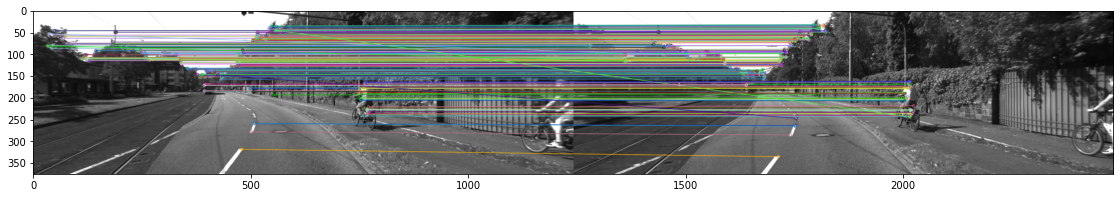

Keeping 146/337 points that match the fundamental matrix
Keeping 24/146 frame3 points, others weren't present in frames1/2


(array([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]]),
 array([[ 1.00000000e+00,  1.35326675e-06, -1.70313056e-06,
          7.07137834e-01],
        [-1.35327012e-06,  1.00000000e+00, -1.97791497e-06,
         -7.07075661e-01],
        [ 1.70312789e-06,  1.97791728e-06,  1.00000000e+00,
          3.05112748e-04]]),
 array([[-8.58344423e-01,  1.99153336e-02, -5.12687265e-01,
          8.40170492e+01],
        [ 2.68198363e-02, -9.96138668e-01, -8.35969483e-02,
          1.51026701e+01],
        [-5.12372470e-01, -8.55051628e-02,  8.54495944e-01,
         -3.08128775e+02]]))

In [133]:
# I made this part up, although it's an amalgamation of code from above which came from other places
points2, points3, matches, _ = detect_matches_and_E(img2, img3)

points3_valid = []

for point2, point3 in zip(points2, points3):
	for cp in point_cloud:
		if np.array_equal(point2, cp.point_2d_2):
			points3_valid.append((cp, point3))
			break

print(f"Keeping {len(points3_valid)}/{len(points3)} frame3 points, others weren't present in frames1/2")

P2 = P_from_PnP((cp for cp, _ in points3_valid), np.array([point3 for cp, point3 in points3_valid]), K)

P, P1, P2